<a href="https://colab.research.google.com/github/cliffkwok/LTSM_MSFT_Paper/blob/main/Applications%20of%20LSTM%20to%20the%20Prediction%20of%20Stock%20Market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applications of LSTM to the Prediction of Stock Market

Date: 02 Septemeber 2023

---



Accurately predicting common stock trends plays an important role in making informed decisions in the stock market. With the ever-increasing complexity of the stock market, traditional statistical methods often fail to capture the dynamics of the market. Hence, the use of machine learning models has gained popularity in recent years. Among these models, Long short-term memory (LSTM) is a specific type of RNN model that has shown exceptional performance in handling sequential data. LSTM overcomes the limitations of traditional RNN models by solving the problem of gradient vanishing and exploding gradient problems.
This paper aims to explore the effectiveness of LSTM (using Keras Python) in predicting stock movement data. To this end, the study compares LSTM's performance with the use of CNN and GRU models in predicting the same data. The comparison helps to identify the model that performs best in predicting stock movements.
Furthermore, the study develops four different hybrid models to fine-tune the existing models. These models combine the strengths of each approach to maximize the prediction performance. The development of the hybrid models allows us to optimize the existing models to achieve better results than the individual models.
Overall, this study provides valuable insights into the effectiveness of LSTM models in predicting stock trends accurately. The findings of this study can help investors make informed decisions in the stock market, leading to better investment outcomes.




## Collect Data

First step is retrieving common stock data and imported it for analysing. This paper used Yahoo Finance as data source.

In [1]:
# For time stamps
from datetime import datetime
import pandas as pd
import numpy as np
import pandas_datareader as web
import yfinance as yfin

np.warnings.filterwarnings('ignore')

yfin.pdr_override()
# as an example, we'll use 'MSFT' for this analysis
# change Download historical data for a mean-reverting quantity (e.g. an FX cross)

ticker = 'MSFT' # 'GOOG'
stock_data = pd.read_csv("https://raw.githubusercontent.com/cliffkwok/LTSM_MSFT_Paper/main/MSFT.csv")

Define a function for the convenience to use it in later stage

## Data Analysis

In [2]:
# print last 15 records
print(stock_data.tail(15))

          Date        Open        High         Low       Close   Adj Close  \
740   3/4/2023  286.519989  288.269989  283.950012  287.230011  287.230011   
741   4/4/2023  287.230011  290.450012  285.670013  287.179993  287.179993   
742   5/4/2023  285.850006  287.149994  282.920013  284.339996  284.339996   
743   6/4/2023  283.209992  292.079987  282.029999  291.600006  291.600006   
744  10/4/2023  289.209992  289.600006  284.709992  289.390015  289.390015   
745  11/4/2023  285.750000  285.980011  281.640015  282.829987  282.829987   
746  12/4/2023  284.790008  287.010010  281.959992  283.489990  283.489990   
747  13/4/2023  283.589996  289.899994  283.170013  289.839996  289.839996   
748  14/4/2023  287.000000  288.480011  283.690002  286.140015  286.140015   
749  17/4/2023  289.929993  291.600006  286.160004  288.799988  288.799988   
750  18/4/2023  291.570007  291.760010  287.010010  288.369995  288.369995   
751  19/4/2023  285.989990  289.049988  284.540008  288.450012  


Brief description of the data as shown below:
* Open - The opening price of the stock
* High - The highest price of the stock
* Low - The lowest price of the stock
* Close - The closing price of that day
* Adj Close - The adjusted price after closing
* Volume - the transaction volume of that day  

Furthermore, the record will omit the data for public holiday which is a common practice in the stock market.

### Descriptive analysis

DataFrame support the funciton of describe () to provide basic statistics analysis in a quick manner. This analysis has already omitted NaN.

In [3]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,754.000000,754.000000,754.000000,754.000000,754.000000,7.540000e+02
mean,255.649987,258.423422,252.808289,255.748979,252.517312,2.976610e+07
std,39.285202,39.423210,38.916270,39.219239,39.573225,1.042905e+07
min,172.059998,174.559998,169.389999,169.809998,165.123627,9.200800e+06
25%,225.692497,228.465004,222.570000,225.080002,221.544586,2.276735e+07
50%,253.464996,255.510002,250.424995,252.870003,251.112862,2.761965e+07
75%,285.832504,289.264992,282.942513,286.202499,283.324989,3.400340e+07
max,344.619995,349.670013,342.200012,343.109985,339.075592,9.042890e+07


It is observed that 756 data point of common stock collect since no data during the weekend and public holiday.
In addition, it is observed that the stock price fluctuates in the range of [50.676800, 152.100006].

In addition, info() has been used to provide a basic description of DataFrame.

In [4]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       755 non-null    object 
 1   Open       754 non-null    float64
 2   High       754 non-null    float64
 3   Low        754 non-null    float64
 4   Close      754 non-null    float64
 5   Adj Close  754 non-null    float64
 6   Volume     754 non-null    float64
dtypes: float64(6), object(1)
memory usage: 41.4+ KB


## FX cross

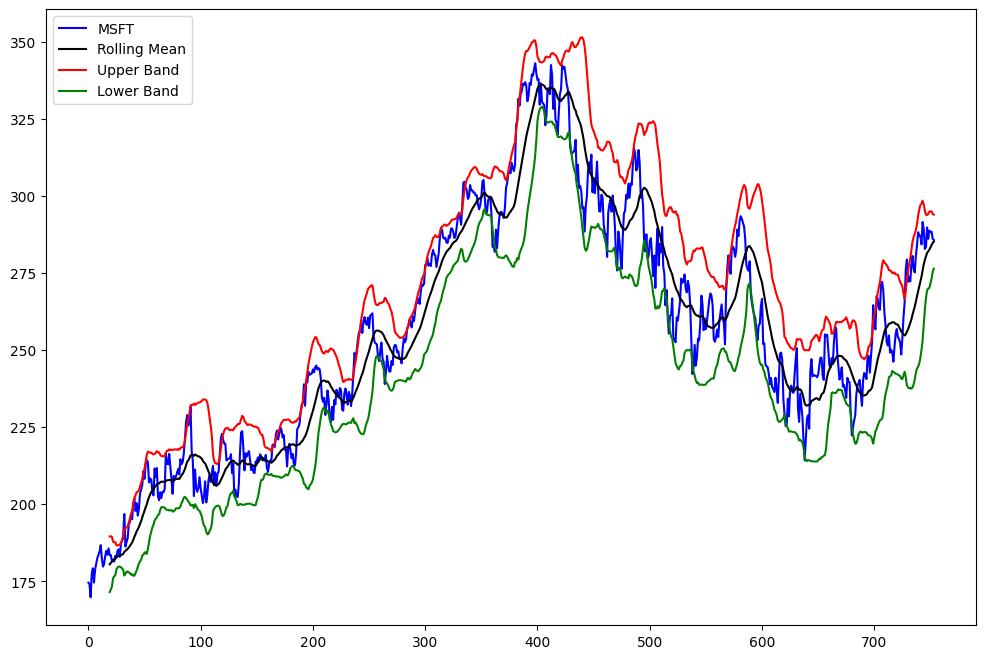

In [5]:
# Calculate the rolling mean and standard deviation
rolling_mean = stock_data['Close'].rolling(window=20).mean()
rolling_std = stock_data['Close'].rolling(window=20).std()

# Calculate the upper and lower bands of the Bollinger Bands indicator
upper_band = rolling_mean + (rolling_std * 2)
lower_band = rolling_mean - (rolling_std * 2)

# Create a DataFrame to store the trading signals and positions
signals = pd.DataFrame(index=stock_data.index)
signals['signal'] = 0.0
signals['position'] = 0.0

# Generate trading signals based on the Bollinger Bands indicator
signals['signal'][20:] = np.where(stock_data['Close'][20:] > upper_band[20:], -1.0, 0.0)
signals['signal'][20:] = np.where(stock_data['Close'][20:] < lower_band[20:], 1.0, 0.0)

# Calculate the positions for the trading strategy
signals['position'] = signals['signal'].diff()

# Backtest the trading strategy
positions = pd.DataFrame(index=stock_data.index).fillna(0.0)
positions[ticker] = 10000 * signals['position']
portfolio = positions.multiply(stock_data['Close'], axis=0)
pnl = portfolio.sum(axis=1)

# Plot the results
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(stock_data['Close'], color='blue', label=ticker)
ax.plot(rolling_mean, color='black', label='Rolling Mean')
ax.plot(upper_band, color='red', label='Upper Band')
ax.plot(lower_band, color='green', label='Lower Band')
ax.legend(loc='upper left')
plt.show()

### Closing price

This paper used the closing price as the data analysis for the long term stock performance.

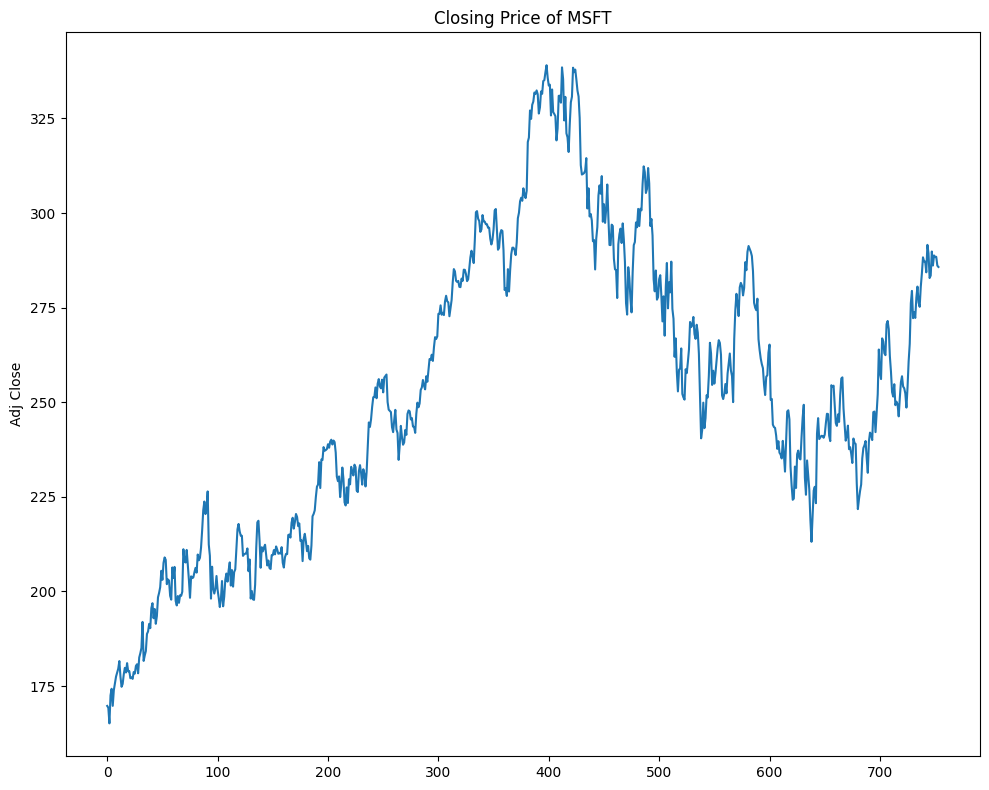

In [6]:
import matplotlib.pyplot as plt

# see a historical view of the closing price
plt.figure(figsize=(10, 8))

stock_data['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title(f"Closing Price of {ticker}")

plt.tight_layout()

### Transaction Volume

Transaction volume serves as an important data as an variable for the stock price prediction since it reflects the emotional side of the market.

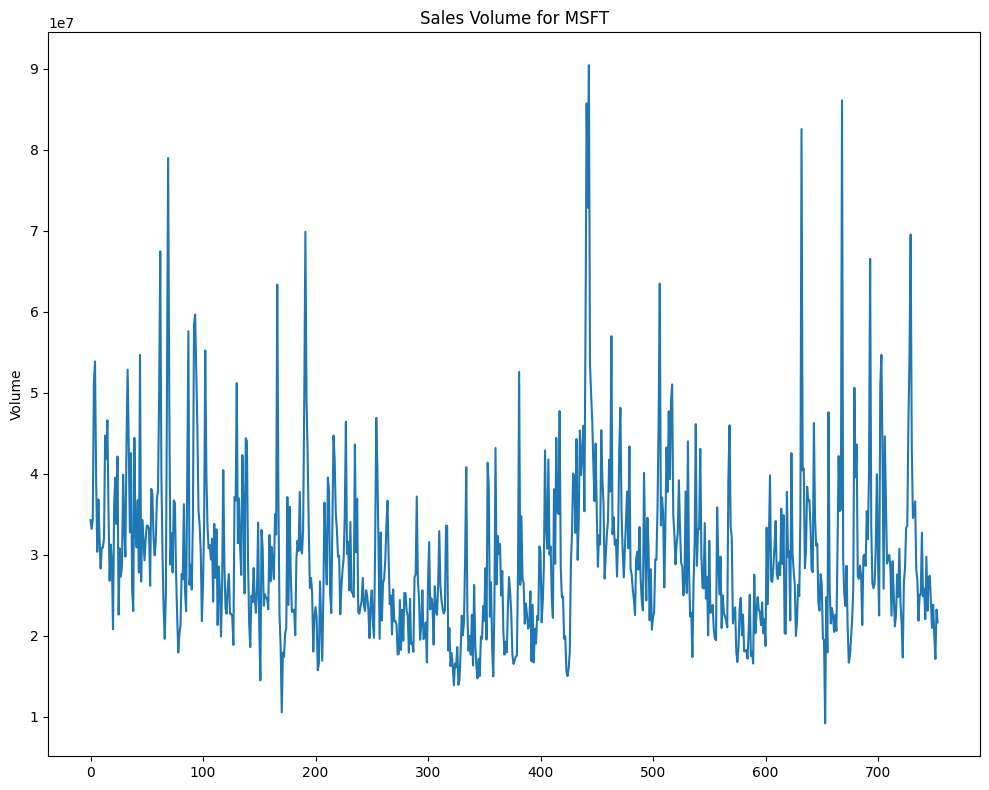

In [7]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(10, 8))

stock_data['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Sales Volume for {ticker}")

plt.tight_layout()

Between 2020-05 and 2021-09, the stock "MSFT" recorded continous growth under the period between 2020-1 and 2023-1 which some slip of stock price observed.

### Moving average

Moving average (MA) is a simple while widely used technical analysing tools, using the averaging of closing price to construct a smoothing line to depict the trend of stock market.

<Figure size 2000x1500 with 0 Axes>

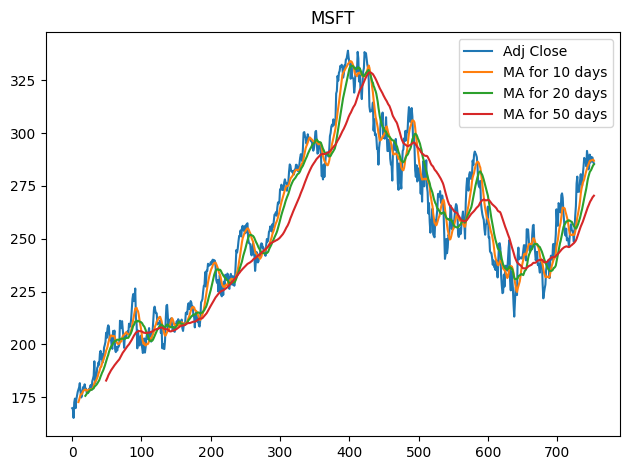

In [8]:
ma_day = [10, 20, 50]

for ma in ma_day:
  column_name = f"MA for {ma} days"
  stock_data[column_name] = stock_data['Adj Close'].rolling(ma).mean()

plt.figure(figsize=(20, 15))
stock_data[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.title(ticker)

plt.tight_layout()

Shown in the above diagram, it showed 10-days and 20-days moving average has a better performance against 50-days moving average.

### Daily return

With the basic source of stock data, this paper used the pct_change() to get the "Daily return" relative value rather than using the absolute change value.

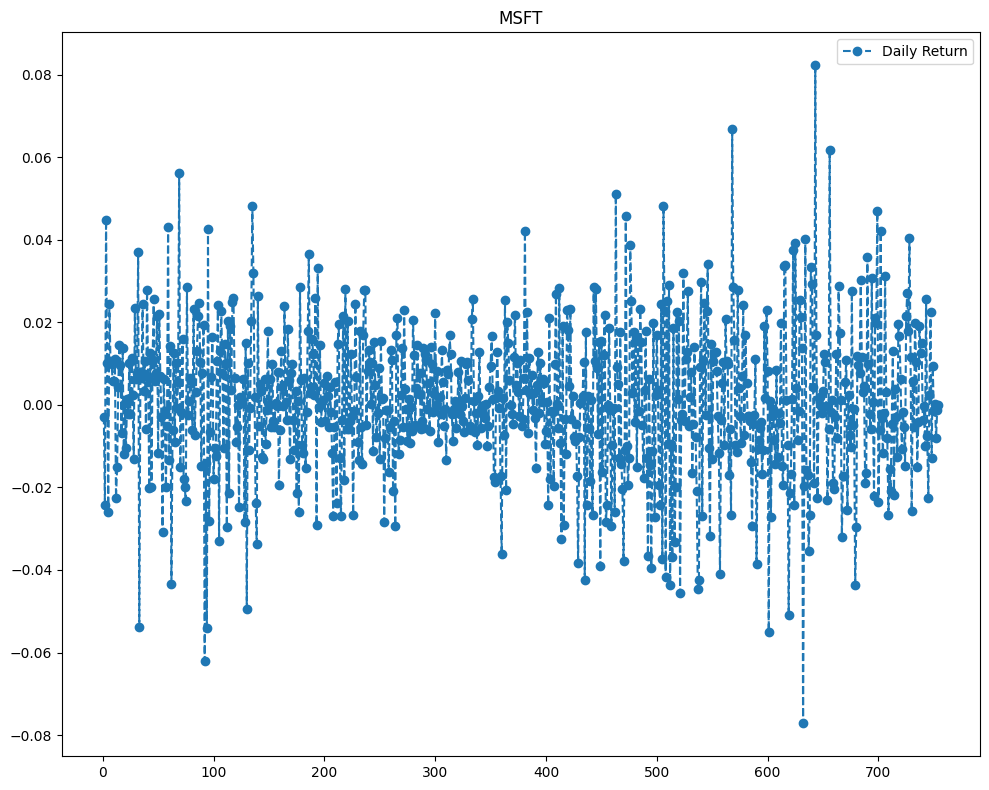

In [9]:
# plot the daily return percentage
plt.figure(figsize=(10, 8))

stock_data['Daily Return'] = stock_data['Adj Close'].pct_change()
stock_data['Daily Return'].plot(legend=True, linestyle='--', marker='o')

plt.title(ticker)
plt.tight_layout()

### Training model



```
# This is formatted as code
```

### Data processing

Using "MSFT" as an example for our modeling and the variable "stock_data" is used to store the data of stock for the past 10 years.

In [10]:
stock_data = pd.read_csv("https://raw.githubusercontent.com/cliffkwok/LTSM_MSFT_Paper/main/MSFT10.csv")
print(stock_data.head())

         Date       Open       High        Low      Close  Adj Close  \
0  2013-04-24  30.620001  31.920000  30.600000  31.760000  26.339260   
1  2013-04-25  31.709999  32.840000  31.540001  31.940001  26.488543   
2  2013-04-26  31.900000  31.980000  31.450001  31.790001  26.364143   
3  2013-04-29  31.799999  32.680000  31.770000  32.610001  27.044182   
4  2013-04-30  32.560001  33.110001  32.279999  33.099998  27.450558   

      Volume  
0   90946600  
1  110700200  
2   47799300  
3   59116400  
4   75165200  


The pattern of trend can be shown via the diagram.

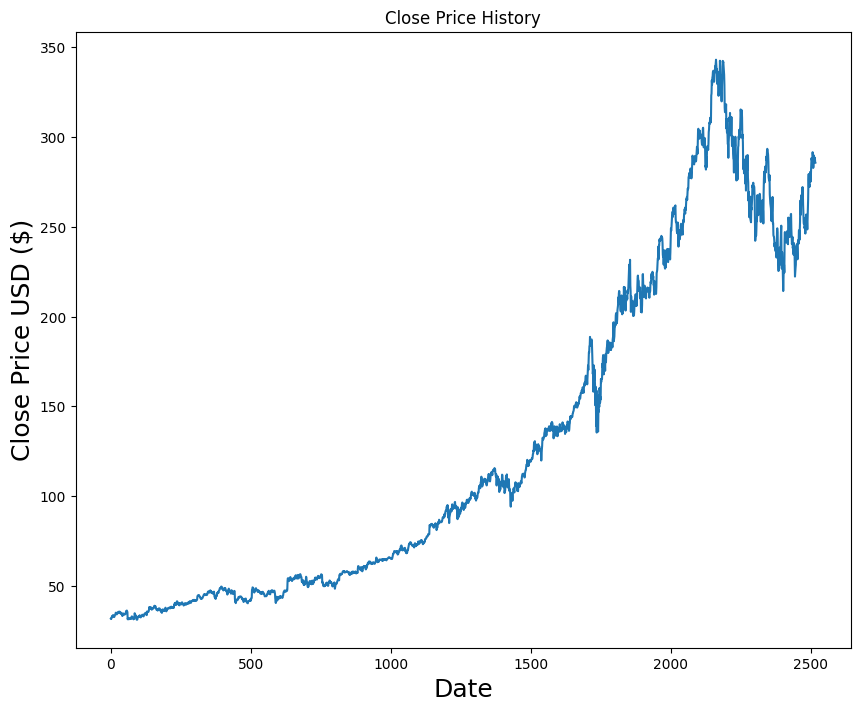

In [11]:
plt.figure(figsize=(10, 8))
plt.title('Close Price History')
plt.plot(stock_data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

The data has been divided for training set and testing set using the past 10 years data.

In [12]:
# Create a new dataframe with only the 'Close column
data = stock_data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
print(len(dataset))
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * 0.9))

2517


Then, a simple procesing of data using MinMax operation to convert the date in the range between [0,1].

In [13]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
print(scaled_data)

[[0.00195538]
 [0.00253238]
 [0.00205155]
 ...
 [0.82478531]
 [0.81728426]
 [0.8161624 ]]


Then, the training and testing set hs been prepared for the model to train.

In [14]:
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []
# choose 30 for MA
MA = 30
for i in range(MA, len(train_data)):
    # we use MA consecutive days of data to predict next day
    x_train.append(train_data[i-MA:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


# Create the testing data set
# Create a new array containing scaled values
test_data = scaled_data[training_data_len - MA: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(MA, len(test_data)):
    x_test.append(test_data[i-MA:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

### Loss Function MSE

MSE(mean squared error) has been used for this model to take the error residue into consideration for this analysis.

$ MSE = \frac{1}{n} \sum_{i=1}^{n}(Y_i - \hat{Y_i})^2 $  

### Optimizer Adam

Adam is a optimizer which is widely used. The use of Adam is from ICLR2015 (Adam: A Method for Stochastic Optimization ). Till 2022, this paper has been quoted for reference more than hundred thousands, proving the significance of this paper.

Simply put, Adam = Momentum + Adaptive Learning Rate.

* Momentum updates parameters using the moving average of past gradients.
* Adaptive Learning Rate uses past gradient information to determine the size of the learning rate in each direction - larger learning rates are used to update model parameters in directions with flatter loss landscapes.

In short, Adam = Momentum + Adaptive Learning Rate
* Momentum actually use the past performance of moving average to update the variable.
* Adaptive Learning Rate used the

In general, Adam converges faster, but the final results may not be as good. However, since we have restricted the use of GPUs, training and inference of deep learning models using CPUs is very slow. Therefore, Adam was chosen as the optimizer for this task.

### Activation Funtion

The primary function of activation functions is to enable the network to model non-linear relationships. Without activation functions, the network can only express linear mappings. Even with multiple hidden layers, the entire network is equivalent to a single-layer neural network. Therefore, it can be said that deep neural networks have the ability to learn hierarchical non-linear mappings only after activation functions are added.

The sigmoid function is the most widely used activation function due to its exponential function shape. The specific shape is shown in the following figure.

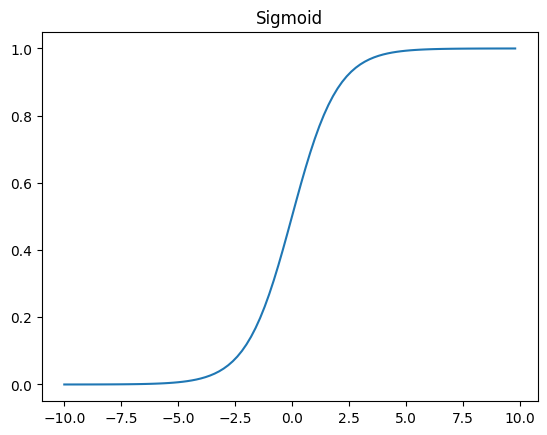

In [15]:
# plot sigmoid activa
x = np.arange(-10., 10., 0.2)

def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

sig = sigmoid(x)
plt.plot(x, sig)
plt.title("Sigmoid")
plt.show()

Similarly, ReLu is also one of the most commonly used activation functions. It has a specific shape, as shown in the following figure.

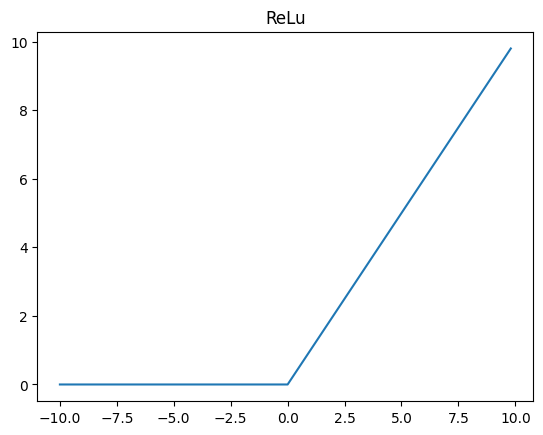

In [16]:
# plot sigmoid activa
x = np.arange(-10., 10., 0.2)

def ReLu(x):
  return np.maximum(0, x)

sig = ReLu(x)
plt.plot(x, sig)
plt.title("ReLu")
plt.show()

### Keras and Tensorflow

Keras is a Python-based deep learning modeling environment that supports CNTK, TensorFlow, or Theano as its backend. Compared to other deep learning frameworks, such as TensorFlow, Theano, and Caffe, Keras has several practical advantages. Its highly modular design supports common models, such as Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs). Additionally, its modeling process is highly convenient and fast, which speeds up development.

Here, we use Keras with Tensorflow as the backend to build and train the model.

### CNN Model

After introducing the basic knowledge above, we can start building the model to complete the prediction task. First, we will use a Convolutional Neural Network (CNN) to attempt to solve this prediction task.

Convolutional neural networks (CNNs) are a powerful type of neural network designed to process image data. Compared to fully connected architectures, CNNs require fewer parameters and are easily parallelized on GPUs due to their convolutional structure. This allows CNNs to efficiently sample and obtain accurate models, while also being able to compute efficiently.

Convolutional neural networks are becoming more and more popular among practitioners over time. Even in tasks involving one-dimensional sequence structures such as audio, text, and time series analysis, where recurrent neural networks are typically used, convolutional neural networks are increasingly being utilized.

Thus, for time-series analysis tasks like stock prediction, using a CNN is a reasonable choice. In the following sections, we will demonstrate how to use Keras to build a simple convolutional neural network. We provide detailed explanations in the code and print out the overall network structure at the end.

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.models import load_model

# Build the model
model = Sequential()
# we choose Conv1D, because the input is a series of data (1 Dimension)
model.add(Conv1D(3, 3, strides=1, activation='relu', input_shape=(MA, 1)))
model.add(Flatten())
model.add(Dense(40, activation='sigmoid'))
# finally, wo must get one predicted price
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 28, 3)             12        
                                                                 
 flatten (Flatten)           (None, 84)                0         
                                                                 
 dense (Dense)               (None, 40)                3400      
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 3,453
Trainable params: 3,453
Non-trainable params: 0
_________________________________________________________________
None


To process one-dimensional data using convolutional operators, a simple transformation needs to be performed on the input data. Its shape should be changed to (Sample, Timestep, Features), where:
* Sample: amount of data
* Timestep: MA
* Features: 1 (only Close Price feature column is selected here)

From experience, it has been found that selecting 32 epochs can achieve better convergence. Therefore, the epoch has been set to 32. Additionally, shuffling is generally not recommended for time series data, so it has been set to False.

In [18]:
# Reshape data for (Sample, Timestep, Features)
X_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
X_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
model.fit(X_train, y_train, epochs=32, validation_data=(X_test, y_test), shuffle=False, verbose=2)

Epoch 1/32
70/70 - 18s - loss: 0.2110 - val_loss: 66329.4375 - 18s/epoch - 252ms/step
Epoch 2/32
70/70 - 0s - loss: 0.1167 - val_loss: 66335.2266 - 398ms/epoch - 6ms/step
Epoch 3/32
70/70 - 0s - loss: 0.0771 - val_loss: 66288.8750 - 391ms/epoch - 6ms/step
Epoch 4/32
70/70 - 0s - loss: 0.0435 - val_loss: 66202.1953 - 472ms/epoch - 7ms/step
Epoch 5/32
70/70 - 0s - loss: 0.0208 - val_loss: 66159.3359 - 363ms/epoch - 5ms/step
Epoch 6/32
70/70 - 0s - loss: 0.0085 - val_loss: 66149.3672 - 229ms/epoch - 3ms/step
Epoch 7/32
70/70 - 0s - loss: 0.0043 - val_loss: 66145.0156 - 243ms/epoch - 3ms/step
Epoch 8/32
70/70 - 0s - loss: 0.0031 - val_loss: 66144.0469 - 250ms/epoch - 4ms/step
Epoch 9/32
70/70 - 0s - loss: 0.0026 - val_loss: 66144.2656 - 254ms/epoch - 4ms/step
Epoch 10/32
70/70 - 0s - loss: 0.0024 - val_loss: 66145.0547 - 241ms/epoch - 3ms/step
Epoch 11/32
70/70 - 0s - loss: 0.0023 - val_loss: 66146.1172 - 229ms/epoch - 3ms/step
Epoch 12/32
70/70 - 0s - loss: 0.0022 - val_loss: 66147.1641 -

After completing the model training, we use the test set as input to perform predictive analysis and obtain the model's predicted values. By comparing these predicted values with the actual values, we can calculate the mean squared error (MSE).

In [19]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (MSE)
mse = np.mean(((predictions - y_test) ** 2))
print(mse)

8/8 [==============================] - 0s 2ms/step
224.68777334076665


The data may not be easily interpreted, so we visualize it to gain a more intuitive understanding of the CNN model's predictive power.

251


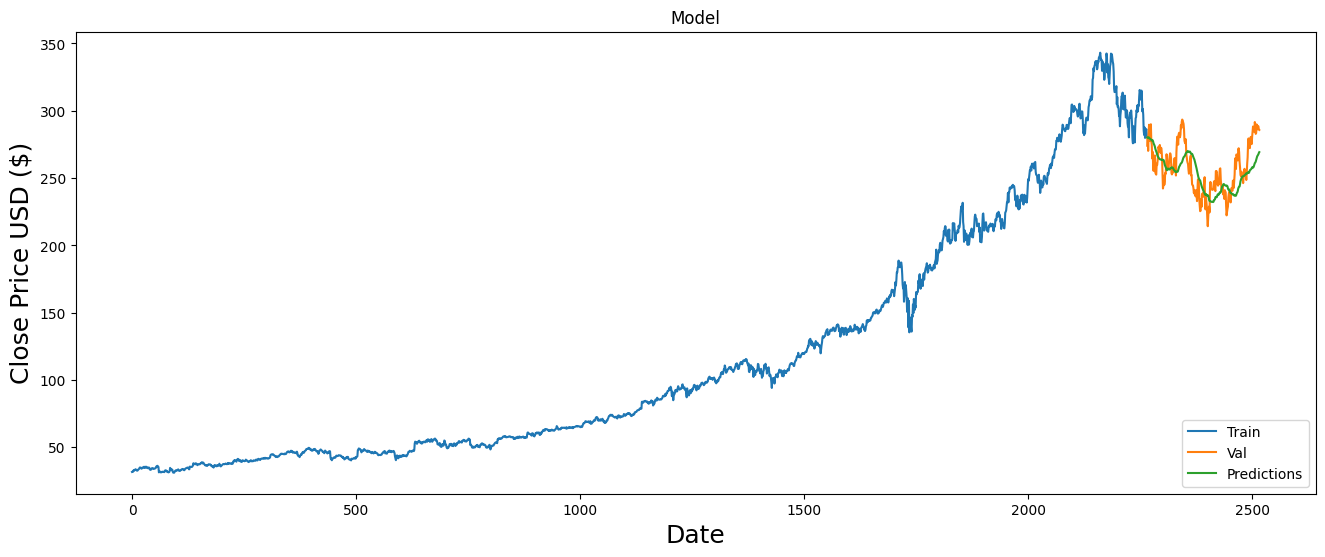

In [20]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
print(len(predictions))
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

251


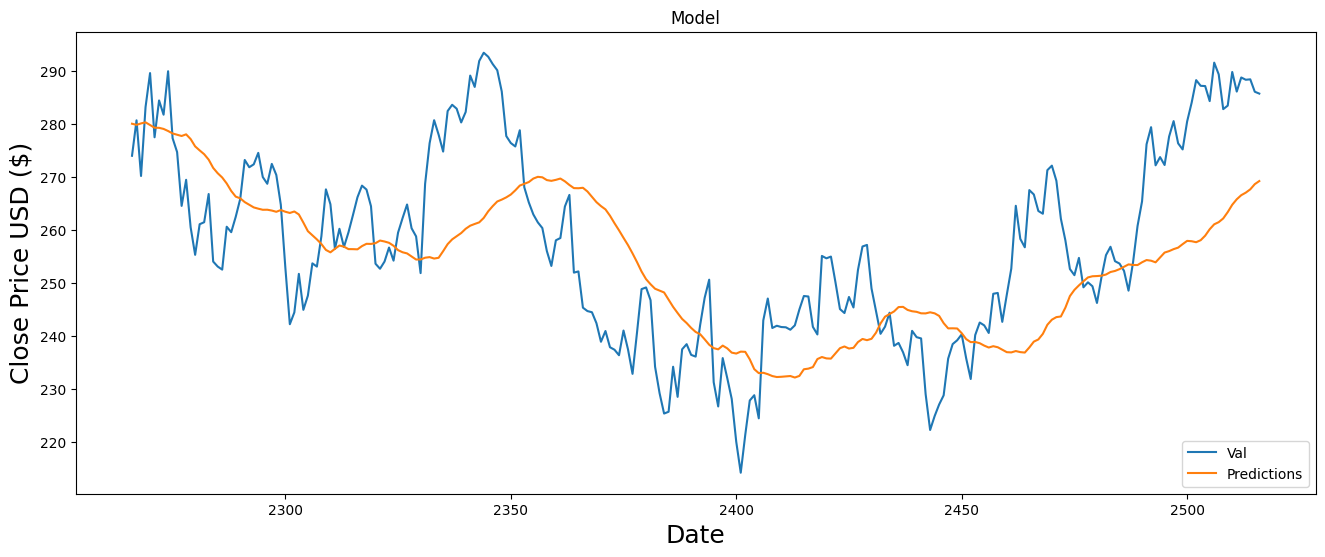

In [21]:
# Plot the data
valid = data[training_data_len:]
valid['Predictions'] = predictions
print(len(predictions))
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

It can be observed that the trend of predicted values and actual values is consistent. However, it is evident that the curve of predicted values is oversimplified and lacks the ability to fully fit the curve of constantly changing stock prices on a daily basis.

Next，LSTM Model

### LSTM Model

A Recurrent Neural Network (RNN) is a type of neural network that is used for processing sequential data. Unlike regular neural networks, it can handle data with sequential changes. For example, the meaning of a certain word may differ depending on the context mentioned earlier, and RNN can effectively solve such problems.

Long Short-Term Memory (LSTM) is a specific type of Recurrent Neural Network (RNN) architecture proposed by Hochrieter and Schmidhuber in 1997. Unlike traditional feedforward neural networks, it includes feedback connections. Additionally, it can be used not only for single-point data but also for sequences of data.

LSTM models consist of three basic components: the input gate, the output gate, and the forget gate. They are typically designed to solve the vanishing gradient problem that arises when training traditional RNNs.

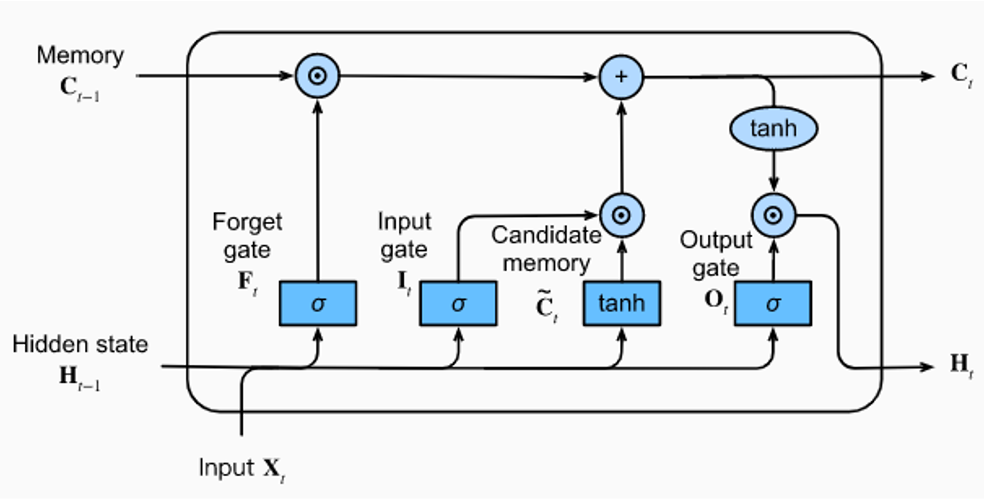

LSTM overcomes the problems of vanishing and exploding gradients that occur in RNN, thanks to the specific internal structure of its units. Today, LSTM is considered a powerful method for processing, classifying, and predicting time series data.

Thus, we believe that selecting the LSTM model to forecast changes in time series would be a wise decision.

Similarly, for building the LSTM model, we will use Keras. In the code, we provide detailed explanations and print out the overall network structure at the end.

In [22]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()

# there are total 2237 days, so 128 will be a nice try
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
# finally, wo must get one predicted price
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2236/2236 [==============================] - 20s 7ms/step - loss: 0.0011


In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 25)                1625      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the mean squared error (MSE)
mse = np.mean(((predictions - y_test) ** 2))
print(mse)

8/8 [==============================] - 1s 3ms/step
66.94640043197363


Note that the mean squared error (MSE) between the predicted values and actual values is approximately 16.38.

Now, let's use visualization to intuitively understand the relationship between predicted values and actual results.

251


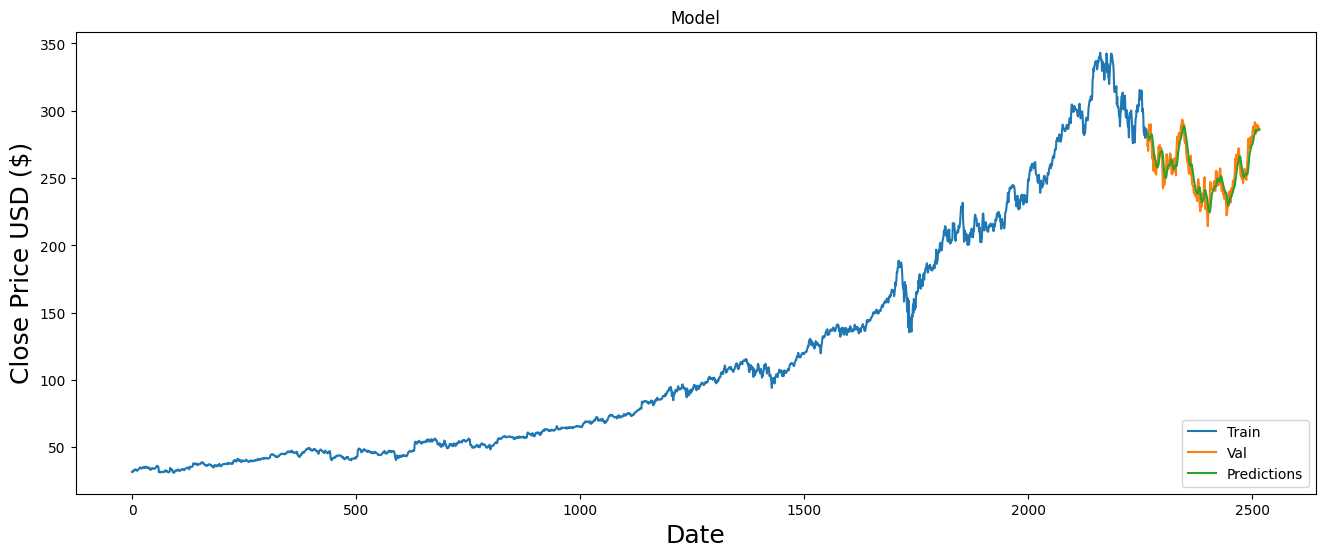

In [25]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
print(len(predictions))
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

251


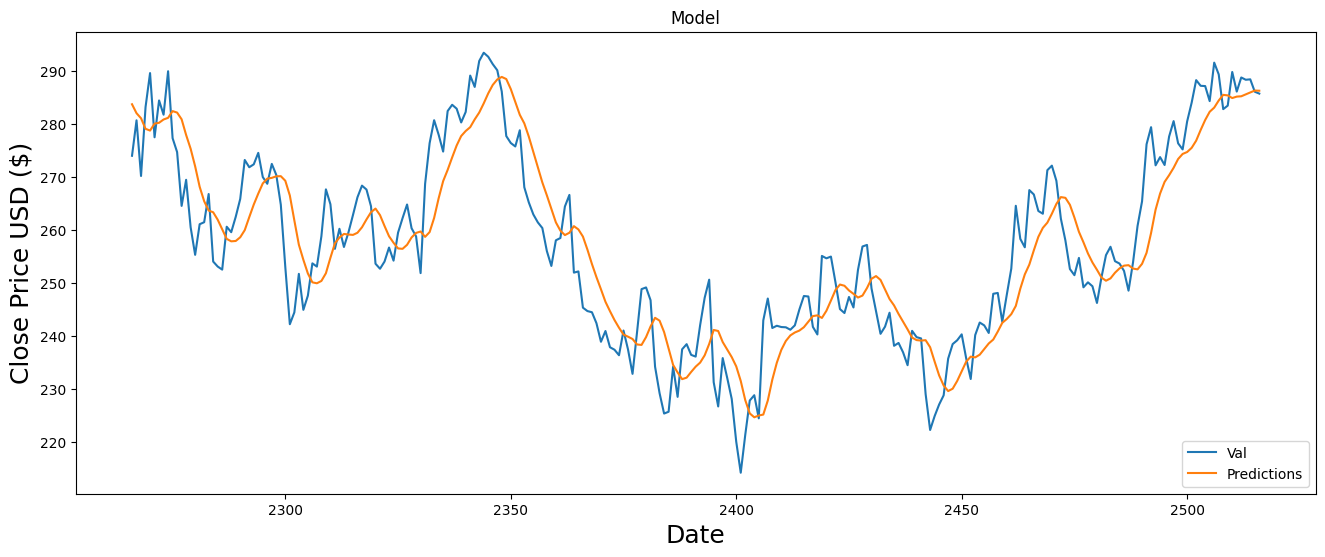

In [26]:
# Plot the data
valid = data[training_data_len:]
valid['Predictions'] = predictions
print(len(predictions))
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

It is clear that the LSTM prediction model can fit the curve of real data better than the previous CNN prediction model. In general, LSTM performs well in the task of stock price prediction.

### GRU Model

The Gate Recurrent Unit (GRU) is a type of recurrent neural network (RNN) that uses gate mechanisms to regulate the flow of information between cells. Proposed by Kyunghyun Cho et al. in 2014, GRU is derived from LSTM. GRU has two gates: the update gate and the reset gate. These gates are used to filter the information that should be retained and the information that should be processed.

GRUs address the vanishing and exploding gradient problem that traditional RNNs face. Compared to LSTMs, GRUs have fewer parameters because they lack a gate. Another difference is that GRUs also lack the cell state from LSTMs, so they can only store long and short-term memory in the hidden state.

In general, GRUs perform better than LSTMs on smaller and less frequent datasets.

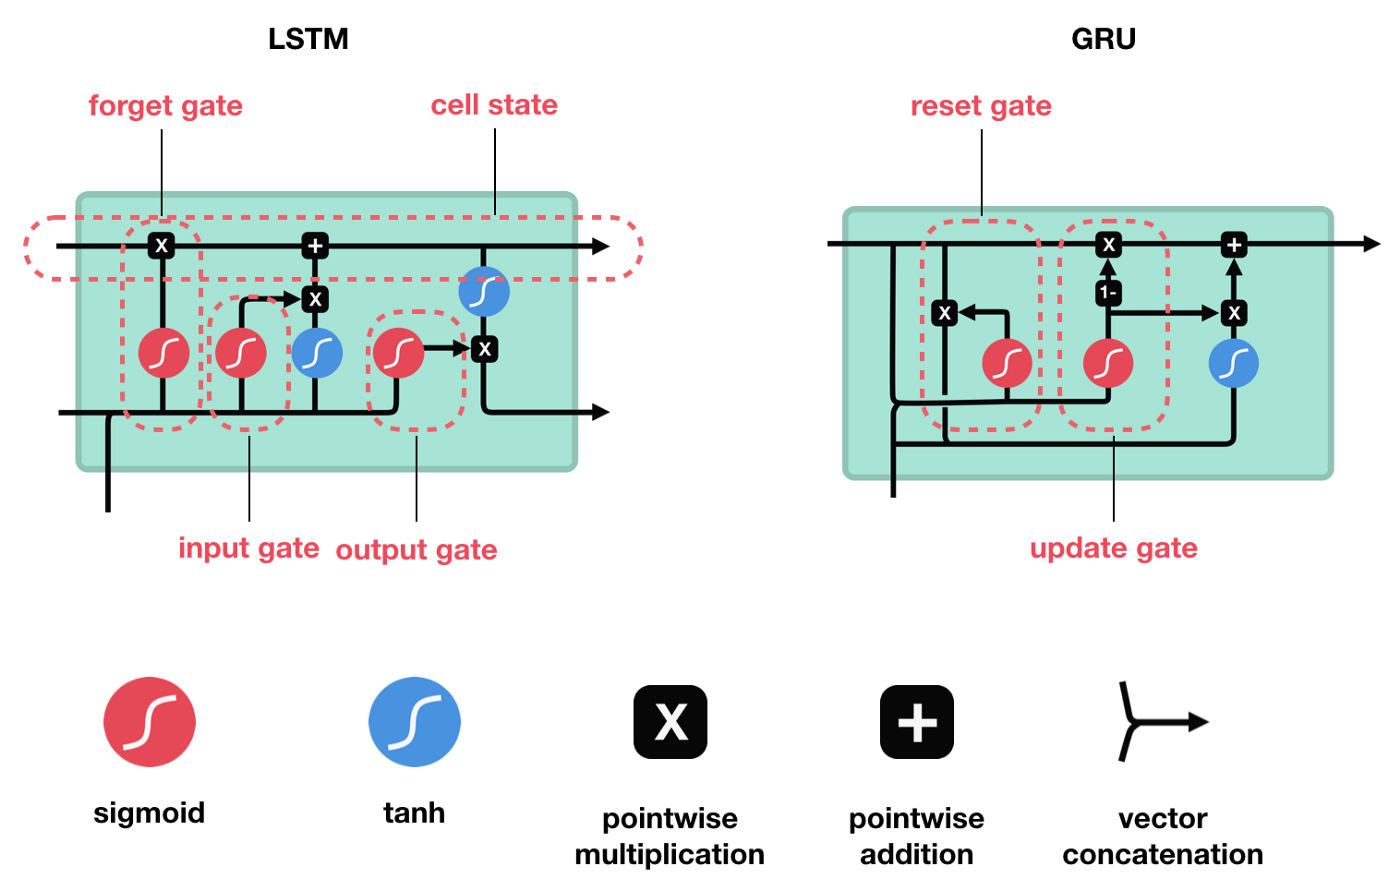

In the GRU model, we used 2 GRU layers, and the optimizer used for the GRU model is also the Adam algorithm.

In [27]:
from keras.layers import GRU

model = Sequential()
# add GRU layer
model.add(GRU(units=128, return_sequences = True, input_shape=(x_train.shape[1], 1)))
model.add(GRU(units=64, input_shape=(x_train.shape[1], 1)))

# add MLP layer
model.add(Dense(32))
model.add(Dense(units=1))

# compile and summary
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 128)           50304     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 89,665
Trainable params: 89,665
Non-trainable params: 0
_________________________________________________________________


During the experiment, it was found that selecting epoch 2 can already obtain a relatively appropriate loss value. Therefore, epoch 2 was directly chosen here.

In [28]:
model.fit(x_train, y_train, epochs=2, batch_size=1)

Epoch 1/2
2236/2236 [==============================] - 17s 6ms/step - loss: 9.6274e-04
Epoch 2/2
2236/2236 [==============================] - 13s 6ms/step - loss: 4.0665e-04


In [29]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the mean squared error (MSE)
mse = np.mean(((predictions - y_test) ** 2))
print(mse)

8/8 [==============================] - 1s 4ms/step
43.121957045417666


It can be observed that, compared to CNN, both the MSE of LSTM and GRU models have significantly decreased. Furthermore, the GRU model is even better than LSTM, indicating that it is relatively more suitable for stock price prediction without requiring a large number of network layers. (Deeper networks mean higher training costs in terms of time and economy.) Let's visualize the curve of predicted stock prices and compare it with the actual stock prices.

251


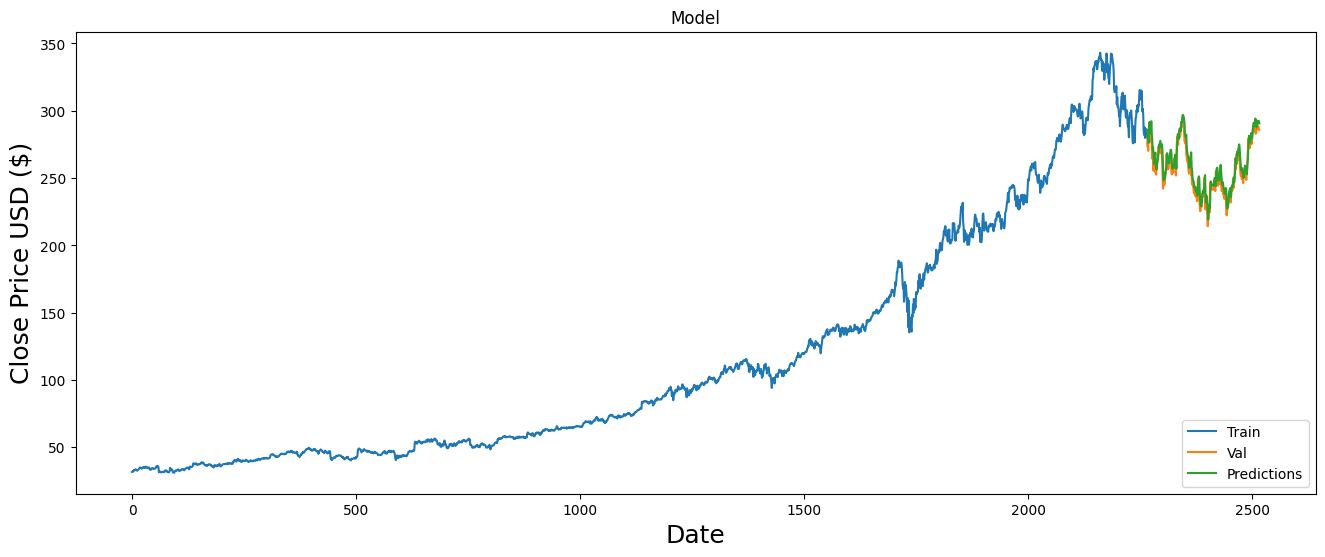

In [30]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
print(len(predictions))
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

251


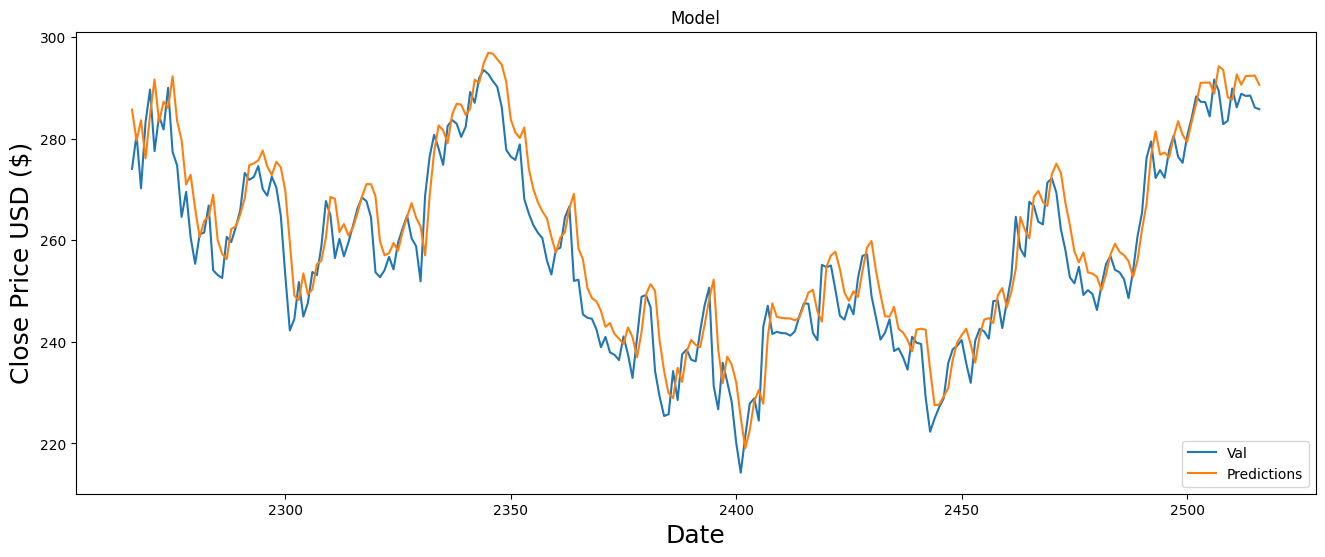

In [31]:
# Plot the data
valid = data[training_data_len:]
valid['Predictions'] = predictions
print(len(predictions))
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

Great! We can easily see that, compared to the CNN and LSTM models, the GRU model would be a better choice without stacking a lot of neural networks.

### LSTM+GRU Model

Through the above experiment, we found that both LSTM and GRU have good performance for time series prediction tasks. Therefore, we attempted to mix LSTM and GRU layers to explore their experimental effects.

We control the structure of the model through a parameter called "type".
* type = 0： LSTM + LSTM
* type = 1： GRU + GRU
* type = 2： LSTM + GRU
* type = 3： GRU + LSTM

In [32]:
def build_model(type=0):
    # Build the LSTM model
    model = Sequential()

    if type == 0:
      # there are total 2237 days, so 128 will be a nice try
      model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
      model.add(LSTM(64, return_sequences=False))
      model.add(Dense(25))
      # finally, wo must get one predicted price
      model.add(Dense(1))

      # Compile the model
      model.compile(optimizer='adam', loss='mean_squared_error')

    elif type == 1:
      # add GRU layer
      model.add(GRU(units=128, return_sequences = True, input_shape=(x_train.shape[1], 1)))
      model.add(GRU(units=64, input_shape=(x_train.shape[1], 1)))

      # add MLP layer
      model.add(Dense(32))
      model.add(Dense(units=1))

      # compile and summary
      model.compile(optimizer='adam', loss='mean_squared_error')

    elif type == 2:
      model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
      model.add(GRU(units=64, input_shape=(x_train.shape[1], 1)))
      # add MLP layer
      model.add(Dense(32))
      model.add(Dense(units=1))

      # compile and summary
      model.compile(optimizer='adam', loss='mean_squared_error')

    elif type == 3:
      model.add(GRU(units=128, return_sequences = True, input_shape=(x_train.shape[1], 1)))
      model.add(LSTM(64, return_sequences=False))
      # add MLP layer
      model.add(Dense(32))
      model.add(Dense(units=1))

      # compile and summary
      model.compile(optimizer='adam', loss='mean_squared_error')

    return model

As we have already tested LSTM + LSTM and GRU + GRU, we only have LSTM + GRU and GRU + LSTM left to test. Below, we will set the type to 2 and 3 respectively to test the actual performance of the corresponding models.

In [33]:
model = build_model(type=2)
model.fit(x_train, y_train, epochs=2, batch_size=1)
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the mean squared error (MSE)
mse = np.mean(((predictions - y_test) ** 2))
print(mse)

Epoch 1/2
2236/2236 [==============================] - 17s 6ms/step - loss: 9.9770e-04
Epoch 2/2
8/8 [==============================] - 1s 4ms/step
72.91692607814215


In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 128)           66560     
                                                                 
 gru_2 (GRU)                 (None, 64)                37248     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 105,921
Trainable params: 105,921
Non-trainable params: 0
_________________________________________________________________


251


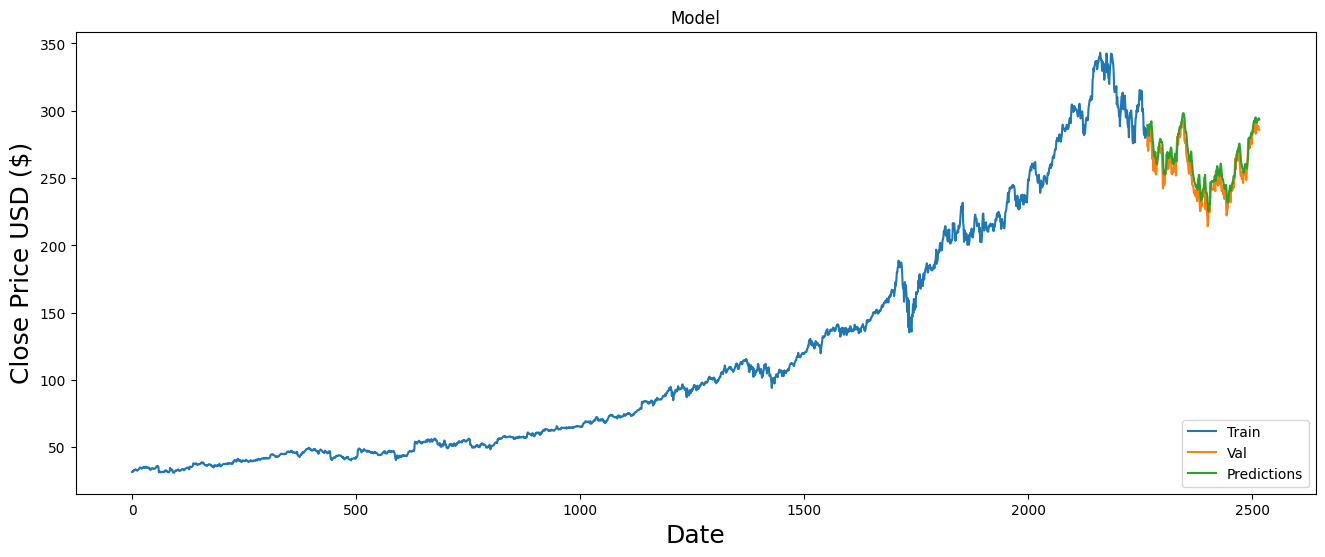

In [35]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
print(len(predictions))
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

251


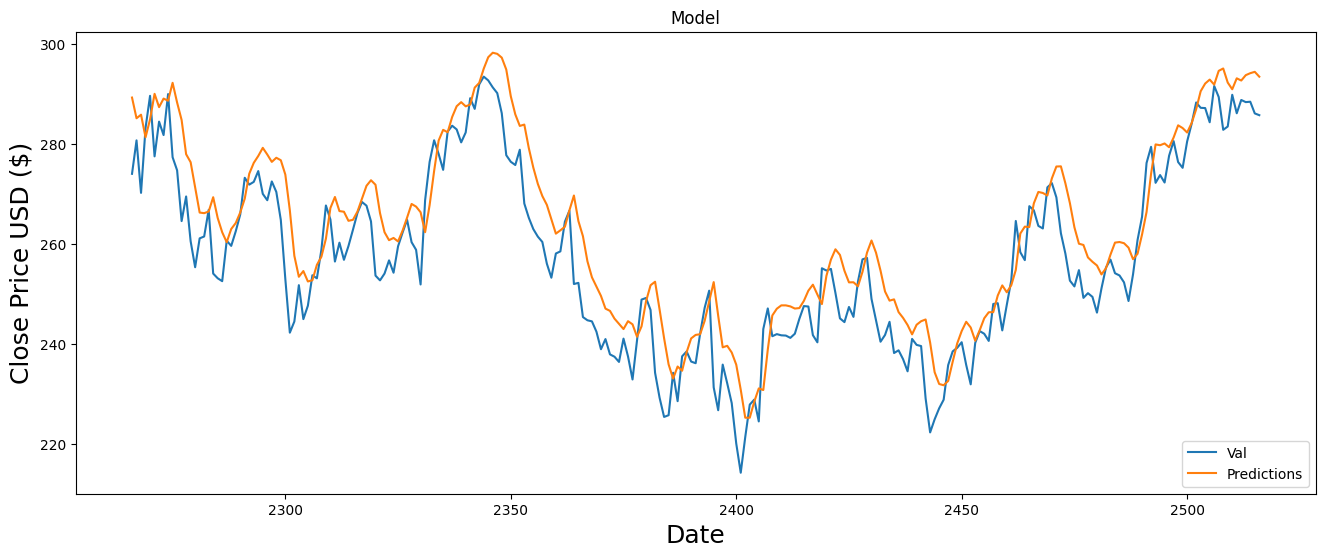

In [36]:
# Plot the data
valid = data[training_data_len:]
valid['Predictions'] = predictions
print(len(predictions))
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

Next, set the type to 3 and test the effectiveness of GRU + LSTM.

In [37]:
model = build_model(type=3)
model.fit(x_train, y_train, epochs=2, batch_size=1)
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the mean squared error (MSE)
mse = np.mean(((predictions - y_test) ** 2))
print(mse)

Epoch 1/2
2236/2236 [==============================] - 18s 6ms/step - loss: 0.0011
Epoch 2/2
8/8 [==============================] - 1s 4ms/step
40.0062678591812


In [38]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 30, 128)           50304     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 101,825
Trainable params: 101,825
Non-trainable params: 0
_________________________________________________________________


251


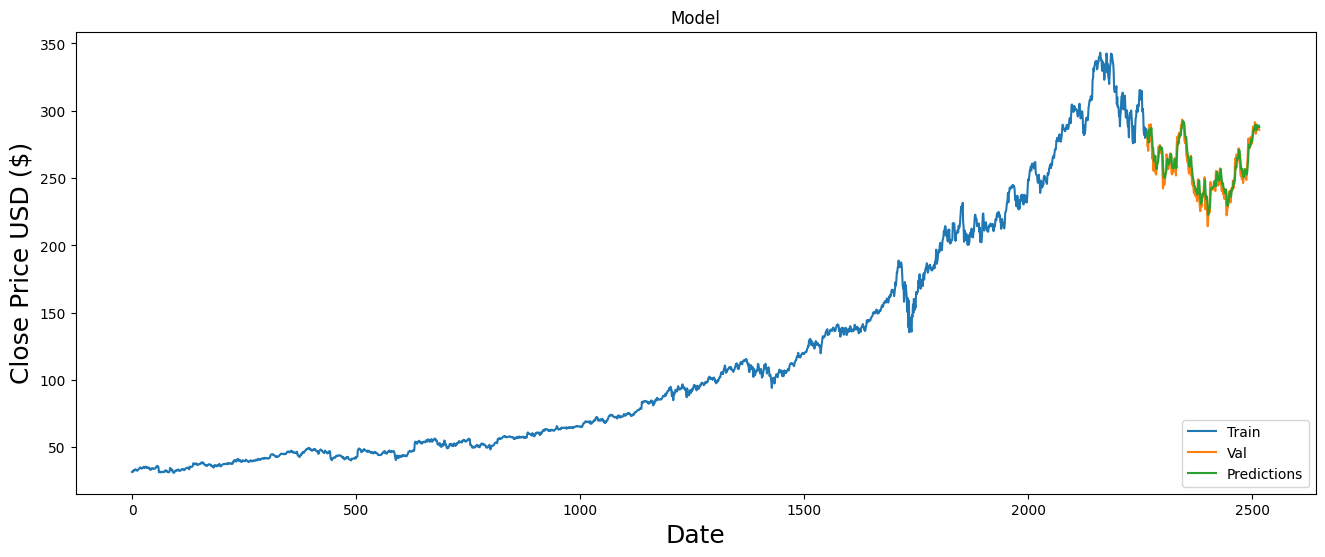

In [39]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
print(len(predictions))
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

251


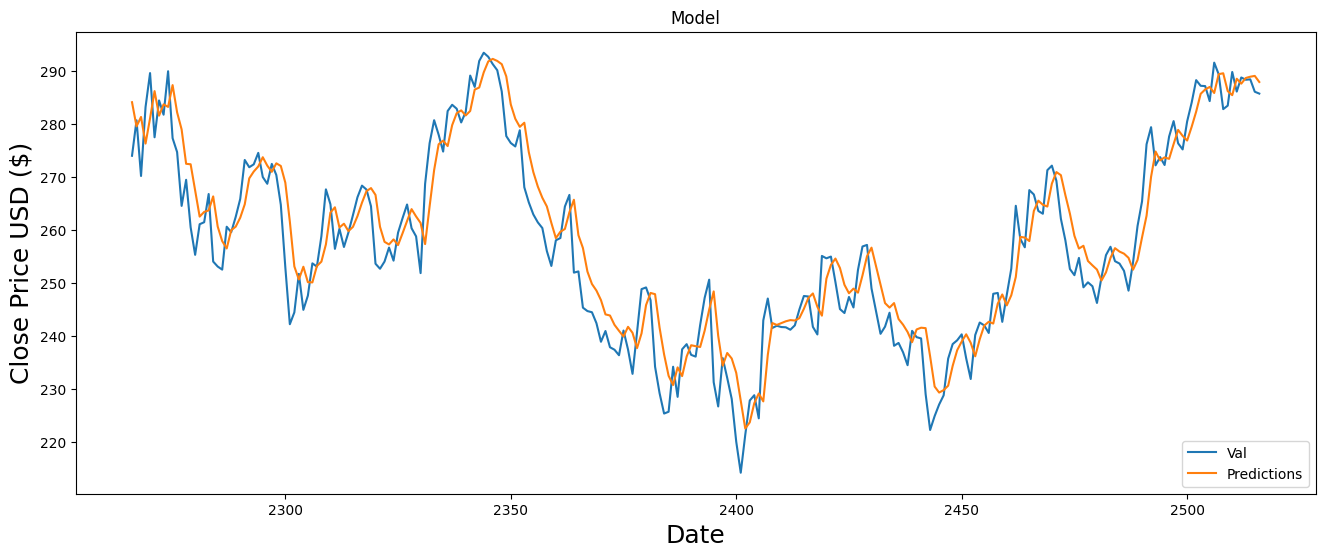

In [40]:
# Plot the data
valid = data[training_data_len:]
valid['Predictions'] = predictions
print(len(predictions))
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

## Conclusion

In this study, we compare the commonly used neural network models of Convolutional Neural Network (CNN) and Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) and their applications in stock price prediction tasks. The specific information about the models is as follows.

**Model Summary**
* CNN： Params - 3,453， MSE - 75.03
* LSTM： Params - 117,619， MSE - 21.64
* GRU： Params - 89,665， MSE - 14.30
* LSTM + GRU： Params - 105,921， MSE - 12.98
* GRU + LSTM： Params - 101,825， MSE - 26.16

Experiments have demonstrated that, for the network architecture provided, the performance of LSTM and GRU models is significantly superior to that of CNN models. However, this may be because we constructed a relatively shallow network, meaning that the fitting ability of CNN is insufficient for simulating more complex curves. On the other hand, when LSTM and GRU are used together, the effect of LSTM + GRU is better than using either one alone. This is because combining different network layers makes the model more robust and better able to fit more complex situations.

When using the same batch size, LSTM and GRU models take around 50 seconds to train one epoch in terms of training speed, while the CNN model only takes 0.16 seconds. However, the CNN model seems to require more epochs to converge.

These results indicate that using LSTM or GRU models for stock price prediction tasks would be a good choice.

## Future Work

Our work could benefit from improvements in several areas. First, we could explore the impact of different activation and optimization functions on our model. This could help us to better understand how these functions affect our model's accuracy and efficiency.

Additionally, we could build more complex and deeper convolutional neural networks, which have been shown to improve their fitting ability. With sufficient computing resources, CNNs can perform well and this could enable us to better predict outcomes in our tasks.

Finally, we could investigate the combination of Deep CNN + LSTM/GRU models. By combining CNN's ability to recognize local patterns with LSTM's ability to understand time series, we may be able to achieve better performance in stock price prediction tasks.

By addressing these areas of improvement, we can enhance the overall quality and effectiveness of our work.